In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Github/brianhelenfakenews/

Train: ISOT + ReCOVery + FA-KES

Test: ISOT, ReCOVery, FA-KES (individually)

In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 313206209539228389
, name: "/device:DML:0"
device_type: "DML"
memory_limit: 7355426407
locality {
}
incarnation: 3565148232146790484
physical_device_desc: "{\"name\": \"AMD Radeon RX 5700 XT\", \"vendor_id\": 4098, \"device_id\": 29471, \"driver_version\": \"30.0.13023.1012\"}"
]


In [5]:
true = pd.read_csv("../Datasets/ISOT/True.csv", dtype=str)
fake = pd.read_csv ("../Datasets/ISOT/Fake.csv", dtype=str)
true.head()
fake.head()

,title,text,subject,date,label,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
true = true.loc[:, ~true.columns.str.contains('^Unnamed')]
fake = fake.loc[:, ~fake.columns.str.contains('^Unnamed')]
fake = fake.drop(columns=fake.columns[0])
fake = fake.drop(columns=fake.columns[1])
fake = fake.drop(columns=fake.columns[1])
true = true.drop(columns=true.columns[0])
true = true.drop(columns=true.columns[1])
true = true.drop(columns=true.columns[1])

In [7]:
true = shuffle(true, random_state=0)
fake = shuffle(fake, random_state=0)

In [8]:
truetrainpercentage = round(len(true)*0.8)
truetotal = len(true)
faketrainpercentage = round(len(fake)*0.8)
faketotal = len(fake)

In [9]:
truetrain = true[0:truetrainpercentage]
truetest = true[truetrainpercentage:truetotal]
faketrain = fake[0:faketrainpercentage]
faketest = fake[faketrainpercentage:faketotal]

In [10]:
fa_kes = pd.read_csv("../Datasets/FA-KESDataset/FA-KES-Dataset.csv")
recovery = pd.read_csv("../Datasets/ReCOVery/recovery-news-data.csv")

In [11]:
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[0])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[1])
fa_kes = fa_kes.drop(columns=fa_kes.columns[2])
fa_kes

,text,label
0,Wed 05 Apr 2017 Syria attack symptoms consiste...,0
1,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,0
2,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,0
3,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,0
4,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,0
...,...,...
799,28-08-2016 Turkish Bombardment Kills 20 Civili...,1
800,17-08-2016 Martyrs as Terrorists Shell Aleppos...,1
801,03-08-2016 Chemical Attack Kills Five Syrians ...,0
802,01-08-2016 5 Killed as Russian Military Choppe...,1


In [12]:
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[0])
recovery = recovery.drop(columns=recovery.columns[1])
recovery = recovery.drop(columns=recovery.columns[1])
recovery

,text,label
0,\nA novel respiratory virus that originated in...,1
1,Chinese Health Officials: More Die From Newly ...,1
2,Public health experts around the globe are scr...,1
3,The first two coronavirus cases in Europe have...,0
4,"A new coronavirus appeared in Wuhan, China, at...",1
...,...,...
2024,© Robert Gauthier/Los Angeles Times/TNS People...,0
2025,"Michael Moore, for decades on the political fr...",0
2026,© HEATHER KHALIFA/The Philadelphia Inquirer/TN...,0
2027,Nearly half of the Twitter accounts sharing in...,0


In [13]:
fa_kes = shuffle(fa_kes, random_state=0)
recovery = shuffle(recovery, random_state=0)

In [31]:
fa_kestrainpercentage = round(len(fa_kes)*0.8)
fa_kestotal = len(fa_kes)
recoverytrainpercentage = round(len(recovery)*0.8)
recoverytotal = len(recovery)

fa_kestrain = fa_kes[0:fa_kestrainpercentage]
fa_kestest = fa_kes[fa_kestrainpercentage:fa_kestotal]
recoverytrain = recovery[0:recoverytrainpercentage]
recoverytest = recovery[recoverytrainpercentage:recoverytotal]

In [32]:
trainframes = [truetrain, faketrain, fa_kestrain, recoverytrain]
train = pd.concat(trainframes)

In [33]:
isottestframes = [truetest, faketest]
isottest = pd.concat(isottestframes)

In [34]:
train

,text,label
17738,GUATEMALA CITY (Reuters) - Former Guatemalan d...,1
18162,"TOKYO (Reuters) - Tokyo Governor Yuriko Koike,...",1
14145,MOGADISHU (Reuters) - Somalia s government sai...,1
19086,BRUSSELS/BERLIN (Reuters) - Jewish groups in E...,1
11813,RIYADH (Reuters) - U.S. President Donald Trump...,1
...,...,...
1348,coronavirus kills too many in dagestanin dages...,0
1300,a table for oneits the creative concept that a...,1
1308,a week ago friday 10 delta airlines jetliners ...,1
470,tiktok creators can now add donation stickers ...,1


In [35]:
import spacy
spacy.load('en_core_web_sm')

In [36]:
#!pip install spacy== 3.0.0
#!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\bliu0\appdata\local\temp\pip-req-build-fhxfueeg
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7691 sha256=7121e1fb2c77c82d34e86d8d2bf509a2c5a209204fb53ce6a13334b2757180c9
  Stored in directory: C:\Users\bliu0\AppData\Local\Temp\pip-ephem-wheel-cache-t2ic073y\wheels\cd\26\af\103cfac199bd773bfc95ed85a52fe9095e4d902ed9ac3b0c97
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\bliu0\AppData\Local\Temp\pip-req-build-fhxfueeg'


In [37]:
import preprocess_kgptalkie as ps

In [38]:
train['text'] = train['text'].apply(lambda x: str(x).lower())
isottest['text'] = isottest['text'].apply(lambda x: str(x).lower())
fa_kes['text'] = fa_kes['text'].apply(lambda x: str(x).lower())
recovery['text'] = recovery['text'].apply(lambda x: str(x).lower())

train['text'] = train['text'].apply(lambda x: ps.remove_special_chars(x))
isottest['text'] = isottest['text'].apply(lambda x: ps.remove_special_chars(x))
fa_kes['text'] = fa_kes['text'].apply(lambda x: ps.remove_special_chars(x))
recovery['text'] = recovery['text'].apply(lambda x: ps.remove_special_chars(x))

In [39]:
train

,text,label
17738,guatemala city reuters former guatemalan dicta...,1
18162,tokyo reuters tokyo governor yuriko koike whos...,1
14145,mogadishu reuters somalia s government said on...,1
19086,brusselsberlin reuters jewish groups in europe...,1
11813,riyadh reuters us president donald trump s rec...,1
...,...,...
1348,coronavirus kills too many in dagestanin dages...,0
1300,a table for oneits the creative concept that a...,1
1308,a week ago friday 10 delta airlines jetliners ...,1
470,tiktok creators can now add donation stickers ...,1


In [40]:
trainx = [d.split() for d in train['text'].tolist()]
trainy = train['label'].values

isotx = [d.split() for d in isottest['text'].tolist()]
isoty = isottest['label'].values

fa_kesx = [d.split() for d in fa_kes['text'].tolist()]
fa_kesy = fa_kes['label'].values

recoveryx = [d.split() for d in recovery['text'].tolist()]
recoveryy = recovery['label'].values

In [41]:
DIM = 400
trainw2v_model = gensim.models.Word2Vec(sentences=trainx, vector_size=DIM, window=10, min_count=1)

isotw2v_model = gensim.models.Word2Vec(sentences=isotx, vector_size=DIM, window=10, min_count=1)

fa_kesw2v_model = gensim.models.Word2Vec(sentences=fa_kesx, vector_size=DIM, window=10, min_count=1)

recoveryw2v_model = gensim.models.Word2Vec(sentences=recoveryx, vector_size=DIM, window=10, min_count=1)

# size --> vector_size

In [42]:
len(trainw2v_model.wv.key_to_index)

len(isotw2v_model.wv.key_to_index)

len(fa_kesw2v_model.wv.key_to_index)

len(recoveryw2v_model.wv.key_to_index)

84171

In [43]:
traintokenizer = tf.keras.preprocessing.text.Tokenizer()
traintokenizer.fit_on_texts(trainx)

isottokenizer = tf.keras.preprocessing.text.Tokenizer()
isottokenizer.fit_on_texts(isotx)

fa_kestokenizer = tf.keras.preprocessing.text.Tokenizer()
fa_kestokenizer.fit_on_texts(fa_kesx)

recoverytokenizer = tf.keras.preprocessing.text.Tokenizer()
recoverytokenizer.fit_on_texts(recoveryx)

In [44]:
trainx = traintokenizer.texts_to_sequences(trainx)

isotx = isottokenizer.texts_to_sequences(isotx)

fa_kesx = fa_kestokenizer.texts_to_sequences(fa_kesx)

recoveryx = recoverytokenizer.texts_to_sequences(recoveryx)

train


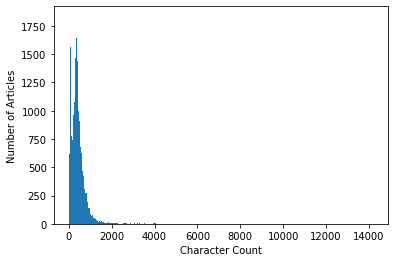

In [45]:
plt.hist([len(a) for a in trainx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("train")
plt.show()

isot


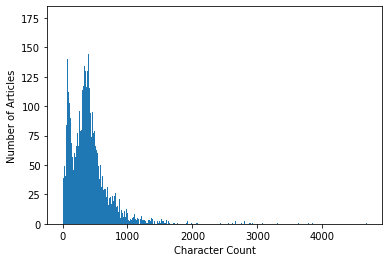

In [46]:
plt.hist([len(a) for a in isotx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("isot")
plt.show()

fa_kes


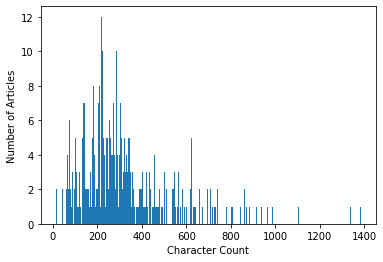

In [47]:
plt.hist([len(a) for a in fa_kesx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("fa_kes")
plt.show()

recovery


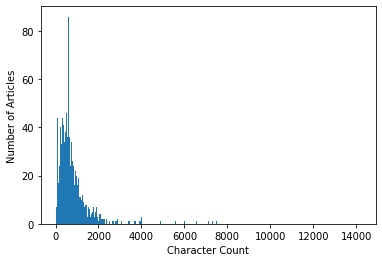

In [48]:
plt.hist([len(a) for a in recoveryx], bins = 700)
plt.xlabel("Character Count")
plt.ylabel("Number of Articles")
print("recovery")
plt.show()

In [49]:
trainnos = np.array([len(a) for a in trainx])
len(trainnos[trainnos>1000])

isotnos = np.array([len(a) for a in isotx])
len(isotnos[isotnos>1000])

fa_kesnos = np.array([len(a) for a in fa_kesx])
len(fa_kesnos[fa_kesnos>1000])

recoverynos = np.array([len(a) for a in recoveryx])
len(recoverynos[recoverynos>1000])

490

In [50]:
maxlen = 100
trainx = tf.keras.preprocessing.sequence.pad_sequences(trainx, maxlen=maxlen)

isotx = tf.keras.preprocessing.sequence.pad_sequences(isotx, maxlen=maxlen)

fa_kesx = tf.keras.preprocessing.sequence.pad_sequences(fa_kesx, maxlen=maxlen)

recoveryx = tf.keras.preprocessing.sequence.pad_sequences(recoveryx, maxlen=maxlen)

In [51]:
trainvocab_size = len(traintokenizer.word_index) + 1
trainvocab = traintokenizer.word_index

isotvocab_size = len(isottokenizer.word_index) + 1
isotvocab = isottokenizer.word_index

fa_kesvocab_size = len(fa_kestokenizer.word_index) + 1
fa_kesvocab = fa_kestokenizer.word_index

recoveryvocab_size = len(recoverytokenizer.word_index) + 1
recoveryvocab = recoverytokenizer.word_index

In [52]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((trainvocab_size, DIM))
    
    for word, i in trainvocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [53]:
embedding_vectors = get_weight_matrix(trainw2v_model)

In [54]:
embedding_vectors.shape

(244502, 400)

In [78]:
model = Sequential()

model.add(Embedding(trainvocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(8, 5, activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid")) 
model.add(LSTM(2))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 400)          97800800  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 8)             16008     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 48, 8)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 88        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 97,816,899
Trainable params: 16,099
Non-trainable params: 97,800,800
_________________________________________________________________


In [79]:
len(trainx)

38202

In [80]:
trainx = np.array(trainx)
trainy = np.array(trainy)

isotx = np.array(isotx)
isoty = np.array(isoty)

fa_kesx = np.array(fa_kesx)
fa_kesy = np.array(fa_kesy)

recoveryx = np.array(recoveryx)
recoveryy = np.array(recoveryy)

In [81]:
model.fit(trainx, trainy, epochs=5)

Train on 38202 samples
Epoch 1/5
38202/38202 [==============================] - 61s 2ms/sample - loss: 0.3755 - acc: 0.9029 - recall_8: 0.9287 - precision_8: 0.8784 - true_negatives_8: 17252.0000 - true_positives_8: 17239.0000 - false_positives_8: 2387.0000 - false_negatives_8: 1324.0000
Epoch 2/5
38202/38202 [==============================] - 60s 2ms/sample - loss: 0.2083 - acc: 0.9393 - recall_8: 0.9587 - precision_8: 0.9199 - true_negatives_8: 18089.0000 - true_positives_8: 17796.0000 - false_positives_8: 1550.0000 - false_negatives_8: 767.0000
Epoch 3/5
38202/38202 [==============================] - 60s 2ms/sample - loss: 0.1657 - acc: 0.9481 - recall_8: 0.9628 - precision_8: 0.9325 - true_negatives_8: 18345.0000 - true_positives_8: 17873.0000 - false_positives_8: 1294.0000 - false_negatives_8: 690.0000
Epoch 4/5
38202/38202 [==============================] - 60s 2ms/sample - loss: 0.1375 - acc: 0.9568 - recall_8: 0.9692 - precision_8: 0.9434 - true_negatives_8: 18560.0000 - true_p

In [82]:
model.evaluate(isotx, isoty)

8983/8983 [==============================] - 6s 651us/sample - loss: 0.9661 - acc: 0.6412 - recall_8: 0.7205 - precision_8: 0.6037 - true_negatives_8: 2674.0000 - true_positives_8: 3086.0000 - false_positives_8: 2026.0000 - false_negatives_8: 1197.0000


[0.9661014319580912,
 0.6412112,
 0.720523,
 0.60367763,
 2674.0,
 3086.0,
 2026.0,
 1197.0]